# Fine-tuning YOLO11 on a Playing Cards dataset
Dataset: https://universe.roboflow.com/augmented-startups/playing-cards-ow27d/dataset/4

by Gholamreza Dar 2024

In [1]:
!pip install -qU ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00


## Huggingface Stuff

In [13]:
# Huggingface login and helper functions
HF_REPO_ID = "Gholamreza/yolo11_poker_hand_detection"

from google.colab import userdata
import huggingface_hub
from huggingface_hub import login, hf_hub_download, HfApi

def save_to_hub(file_name, file_in_repo_name=None, repo_id=HF_REPO_ID):
    if file_in_repo_name == None:
        file_in_repo_name = file_name

    api = HfApi()
    api.upload_file(
        path_or_fileobj=file_name,
        path_in_repo=file_in_repo_name,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f">> Uploaded {file_name} to {repo_id}/{file_in_repo_name}")

def save_folder_to_hub(folder_name, repo_id=HF_REPO_ID):
    api = HfApi()
    api.upload_folder(
        folder_path=folder_name,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f">> Uploaded {folder_name} to {repo_id}/{folder_name}")

def load_from_hub(folder_in_repo, repo_id=HF_REPO_ID):
    return hf_hub_download(repo_id=repo_id, filename=folder_in_repo)

login(token=userdata.get('HF_TOKEN'))

## Download and prepare the data

Dataset: [Playing Cards Dataset](https://universe.roboflow.com/augmented-startups/playing-cards-ow27d/dataset/4) on roboflow universe

In [3]:
from roboflow import Roboflow
from google.colab import userdata

token = userdata.get('RF_TOKEN')
rf = Roboflow(api_key=token)
project = rf.workspace("augmented-startups").project("playing-cards-ow27d")
version = project.version(4)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Playing-Cards-4 in yolov11:: 100%|██████████| 48478/48478 [00:17<00:00, 2787.07it/s]


In [4]:
# what is the size of the dataset in MB
!du -sh {dataset.location}

2.2G	/content/Playing-Cards-4


In [5]:
print("name:", dataset.name)
print("version:", dataset.version)
print("model_format:", dataset.model_format)
print("location:", dataset.location) # we need this later

name: Playing Cards
version: 4
model_format: yolov11
location: /content/Playing-Cards-4


In [6]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 52
names: ['10C', '10D', '10H', '10S', '2C', '2D', '2H', '2S', '3C', '3D', '3H', '3S', '4C', '4D', '4H', '4S', '5C', '5D', '5H', '5S', '6C', '6D', '6H', '6S', '7C', '7D', '7H', '7S', '8C', '8D', '8H', '8S', '9C', '9D', '9H', '9S', 'AC', 'AD', 'AH', 'AS', 'JC', 'JD', 'JH', 'JS', 'KC', 'KD', 'KH', 'KS', 'QC', 'QD', 'QH', 'QS']

roboflow:
  workspace: augmented-startups
  project: playing-cards-ow27d
  version: 4
  license: Public Domain
  url: https://universe.roboflow.com/augmented-startups/playing-cards-ow27d/dataset/4

## Fine-tune the model

In [14]:
from ultralytics import YOLO
import os

# Load a pretrained YOLOv11 model
model = YOLO('yolo11n.pt')

# Fine-tune the model using the dataset
results = model.train(
    data=os.path.join(dataset.location, "data.yaml"),
    epochs=30,
    imgsz=640,
    batch=-1, # 60% GPU util.
    # save_period=5,
    name='yolo11n_poker',
    fraction=1,
    val=True,
    plots=True,
)

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/Playing-Cards-4/data.yaml, epochs=30, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n_poker3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

train: Scanning /content/Playing-Cards-4/train/labels.cache... 21203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21203/21203 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 6.85G reserved, 1.38G allocated, 6.52G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2599980       6.495         0.503         29.47         17.43        (1, 3, 640, 640)                    list
     2599980       12.99         0.587         29.28         19.72        (2, 3, 640, 640)                    list
     2599980       25.98         0.858         31.09         23.45        (4, 3, 640, 640)                    list
     2599980       51.96         1.405         33.58         35.76        (8, 3, 640, 640)                    list
     2599980       103.9         2.544         59.07         67.37       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 26 for CUDA:0 12.14G/14.75G (82%) ✅


train: Scanning /content/Playing-Cards-4/train/labels.cache... 21203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21203/21203 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Playing-Cards-4/valid/labels.cache... 2020 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2020/2020 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11n_poker3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000179, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00040625000000000004), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11n_poker3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.35G      1.543      4.352       1.11         97        640: 100%|██████████| 816/816 [07:51<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:23<00:00,  1.68it/s]


                   all       2020       8080      0.125      0.312      0.136     0.0768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       4.3G      1.324      2.614      1.038         86        640: 100%|██████████| 816/816 [07:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


                   all       2020       8080      0.563      0.729      0.681        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.29G      1.264      1.755      1.034         96        640: 100%|██████████| 816/816 [07:21<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:21<00:00,  1.78it/s]


                   all       2020       8080      0.888      0.896      0.958      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.24G      1.232       1.29      1.031         78        640: 100%|██████████| 816/816 [07:26<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.95it/s]

                   all       2020       8080      0.963      0.966       0.99      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.24G       1.21      1.053      1.031         74        640: 100%|██████████| 816/816 [07:30<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.86it/s]


                   all       2020       8080      0.986      0.988      0.994      0.733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.28G      1.194     0.9313      1.032         78        640: 100%|██████████| 816/816 [07:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:21<00:00,  1.79it/s]


                   all       2020       8080      0.991       0.99      0.995      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.28G      1.182     0.8463      1.029         76        640: 100%|██████████| 816/816 [07:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:21<00:00,  1.82it/s]


                   all       2020       8080      0.993      0.995      0.995      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.28G      1.174     0.7946       1.03         84        640: 100%|██████████| 816/816 [07:18<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:22<00:00,  1.76it/s]

                   all       2020       8080      0.996      0.996      0.995      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.27G      1.166     0.7529      1.027         61        640: 100%|██████████| 816/816 [07:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  2.01it/s]

                   all       2020       8080      0.996      0.997      0.995      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.23G      1.158     0.7168      1.027         74        640: 100%|██████████| 816/816 [07:13<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  1.95it/s]

                   all       2020       8080      0.996      0.997      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.29G      1.154     0.6882      1.026         85        640: 100%|██████████| 816/816 [07:20<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  1.95it/s]

                   all       2020       8080      0.997      0.998      0.995      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.29G      1.149     0.6717      1.023        108        640: 100%|██████████| 816/816 [07:21<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:21<00:00,  1.84it/s]

                   all       2020       8080      0.997      0.999      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.29G      1.143     0.6532      1.022         67        640: 100%|██████████| 816/816 [07:19<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]

                   all       2020       8080      0.998      0.999      0.995      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.31G      1.138     0.6362       1.02         74        640: 100%|██████████| 816/816 [07:18<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:18<00:00,  2.05it/s]

                   all       2020       8080      0.998      0.999      0.995      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.23G      1.137     0.6224      1.021         59        640: 100%|██████████| 816/816 [07:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]

                   all       2020       8080      0.998      0.999      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.26G       1.13     0.6129      1.017         51        640: 100%|██████████| 816/816 [07:19<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]

                   all       2020       8080      0.998      0.999      0.995      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.31G      1.126     0.6031      1.018         96        640: 100%|██████████| 816/816 [07:20<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]

                   all       2020       8080      0.998      0.999      0.995      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.23G      1.122     0.5925      1.015         64        640: 100%|██████████| 816/816 [07:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  2.02it/s]

                   all       2020       8080      0.998      0.999      0.995       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.29G      1.117     0.5817      1.011         66        640: 100%|██████████| 816/816 [07:16<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]

                   all       2020       8080      0.998      0.999      0.995      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.29G      1.109      0.575      1.009         72        640: 100%|██████████| 816/816 [07:17<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  2.02it/s]

                   all       2020       8080      0.999      0.999      0.995       0.82


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.25G      1.116     0.4713      1.074         52        640: 100%|██████████| 816/816 [07:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  1.98it/s]

                   all       2020       8080      0.999      0.999      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.25G      1.102     0.4622      1.069         51        640: 100%|██████████| 816/816 [06:55<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:21<00:00,  1.85it/s]

                   all       2020       8080      0.999      0.999      0.995      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.25G      1.095      0.457      1.066         51        640: 100%|██████████| 816/816 [06:55<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.93it/s]

                   all       2020       8080      0.999      0.999      0.995      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.25G      1.079       0.45      1.059         49        640: 100%|██████████| 816/816 [06:57<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.95it/s]

                   all       2020       8080      0.999      0.999      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.25G       1.07     0.4449      1.056         50        640: 100%|██████████| 816/816 [06:49<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.91it/s]


                   all       2020       8080      0.999      0.999      0.995      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.25G      1.061     0.4418       1.05         51        640: 100%|██████████| 816/816 [06:51<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  2.00it/s]

                   all       2020       8080      0.999      0.999      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.25G      1.056     0.4368      1.048         51        640: 100%|██████████| 816/816 [06:50<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.88it/s]

                   all       2020       8080      0.999      0.999      0.995      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.25G      1.052     0.4347      1.045         51        640: 100%|██████████| 816/816 [06:48<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:20<00:00,  1.90it/s]

                   all       2020       8080      0.999      0.999      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.25G      1.047     0.4275      1.045         52        640: 100%|██████████| 816/816 [06:56<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  1.98it/s]

                   all       2020       8080      0.999      0.999      0.995       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.25G      1.044     0.4265      1.044         51        640: 100%|██████████| 816/816 [06:55<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:19<00:00,  1.97it/s]

                   all       2020       8080      0.999      0.999      0.995      0.828



30 epochs completed in 3.784 hours.
Optimizer stripped from runs/detect/yolo11n_poker3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_poker3/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_poker3/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,592,292 parameters, 0 gradients, 6.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:24<00:00,  1.60it/s]


                   all       2020       8080      0.999      0.999      0.995       0.83
                   10C        129        172      0.999          1      0.995      0.838
                   10D        124        161      0.999          1      0.995      0.836
                   10H        103        148      0.999          1      0.995      0.849
                   10S        112        153          1          1      0.995      0.841
                    2C        106        144      0.998          1      0.995      0.833
                    2D        117        165      0.999          1      0.995      0.827
                    2H        136        183      0.999          1      0.995      0.839
                    2S        102        137      0.998          1      0.995      0.841
                    3C        122        176      0.999          1      0.995      0.846
                    3D        106        145          1      0.992      0.995      0.847
                    3

In [15]:
save_folder_to_hub("runs")

events.out.tfevents.1734399885.9ad9e8249a8e.758.0:   0%|          | 0.00/271k [00:00<?, ?B/s]

events.out.tfevents.1734400052.9ad9e8249a8e.758.1:   0%|          | 0.00/271k [00:00<?, ?B/s]

events.out.tfevents.1734400193.9ad9e8249a8e.758.2:   0%|          | 0.00/290k [00:00<?, ?B/s]

best.pt:   0%|          | 0.00/5.49M [00:00<?, ?B/s]

last.pt:   0%|          | 0.00/5.49M [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

>> Uploaded runs to Gholamreza/yolo11_poker_hand_detection/runs


In [16]:
# evaulate on the test set https://docs.ultralytics.com/modes/val/#can-i-validate-my-yolo11-model-using-a-custom-dataset
metrics = model.val()  # assumes `model` has been loaded
print(metrics.box.map)  # mAP50-95
print(metrics.box.map50)  # mAP50
print(metrics.box.map75)  # mAP75
print(metrics.box.maps)  # list of mAP50-95 for each category

Ultralytics 8.3.50 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,592,292 parameters, 0 gradients, 6.4 GFLOPs


val: Scanning /content/Playing-Cards-4/valid/labels.cache... 2020 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2020/2020 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:28<00:00,  2.73it/s]


                   all       2020       8080      0.999      0.999      0.995       0.83
                   10C        129        172      0.999          1      0.995      0.838
                   10D        124        161      0.999          1      0.995      0.838
                   10H        103        148      0.999          1      0.995       0.85
                   10S        112        153          1          1      0.995      0.843
                    2C        106        144      0.998          1      0.995      0.828
                    2D        117        165      0.999          1      0.995      0.828
                    2H        136        183      0.999          1      0.995      0.841
                    2S        102        137      0.998          1      0.995      0.844
                    3C        122        176      0.999          1      0.995      0.845
                    3D        106        145          1      0.992      0.995      0.847
                    3

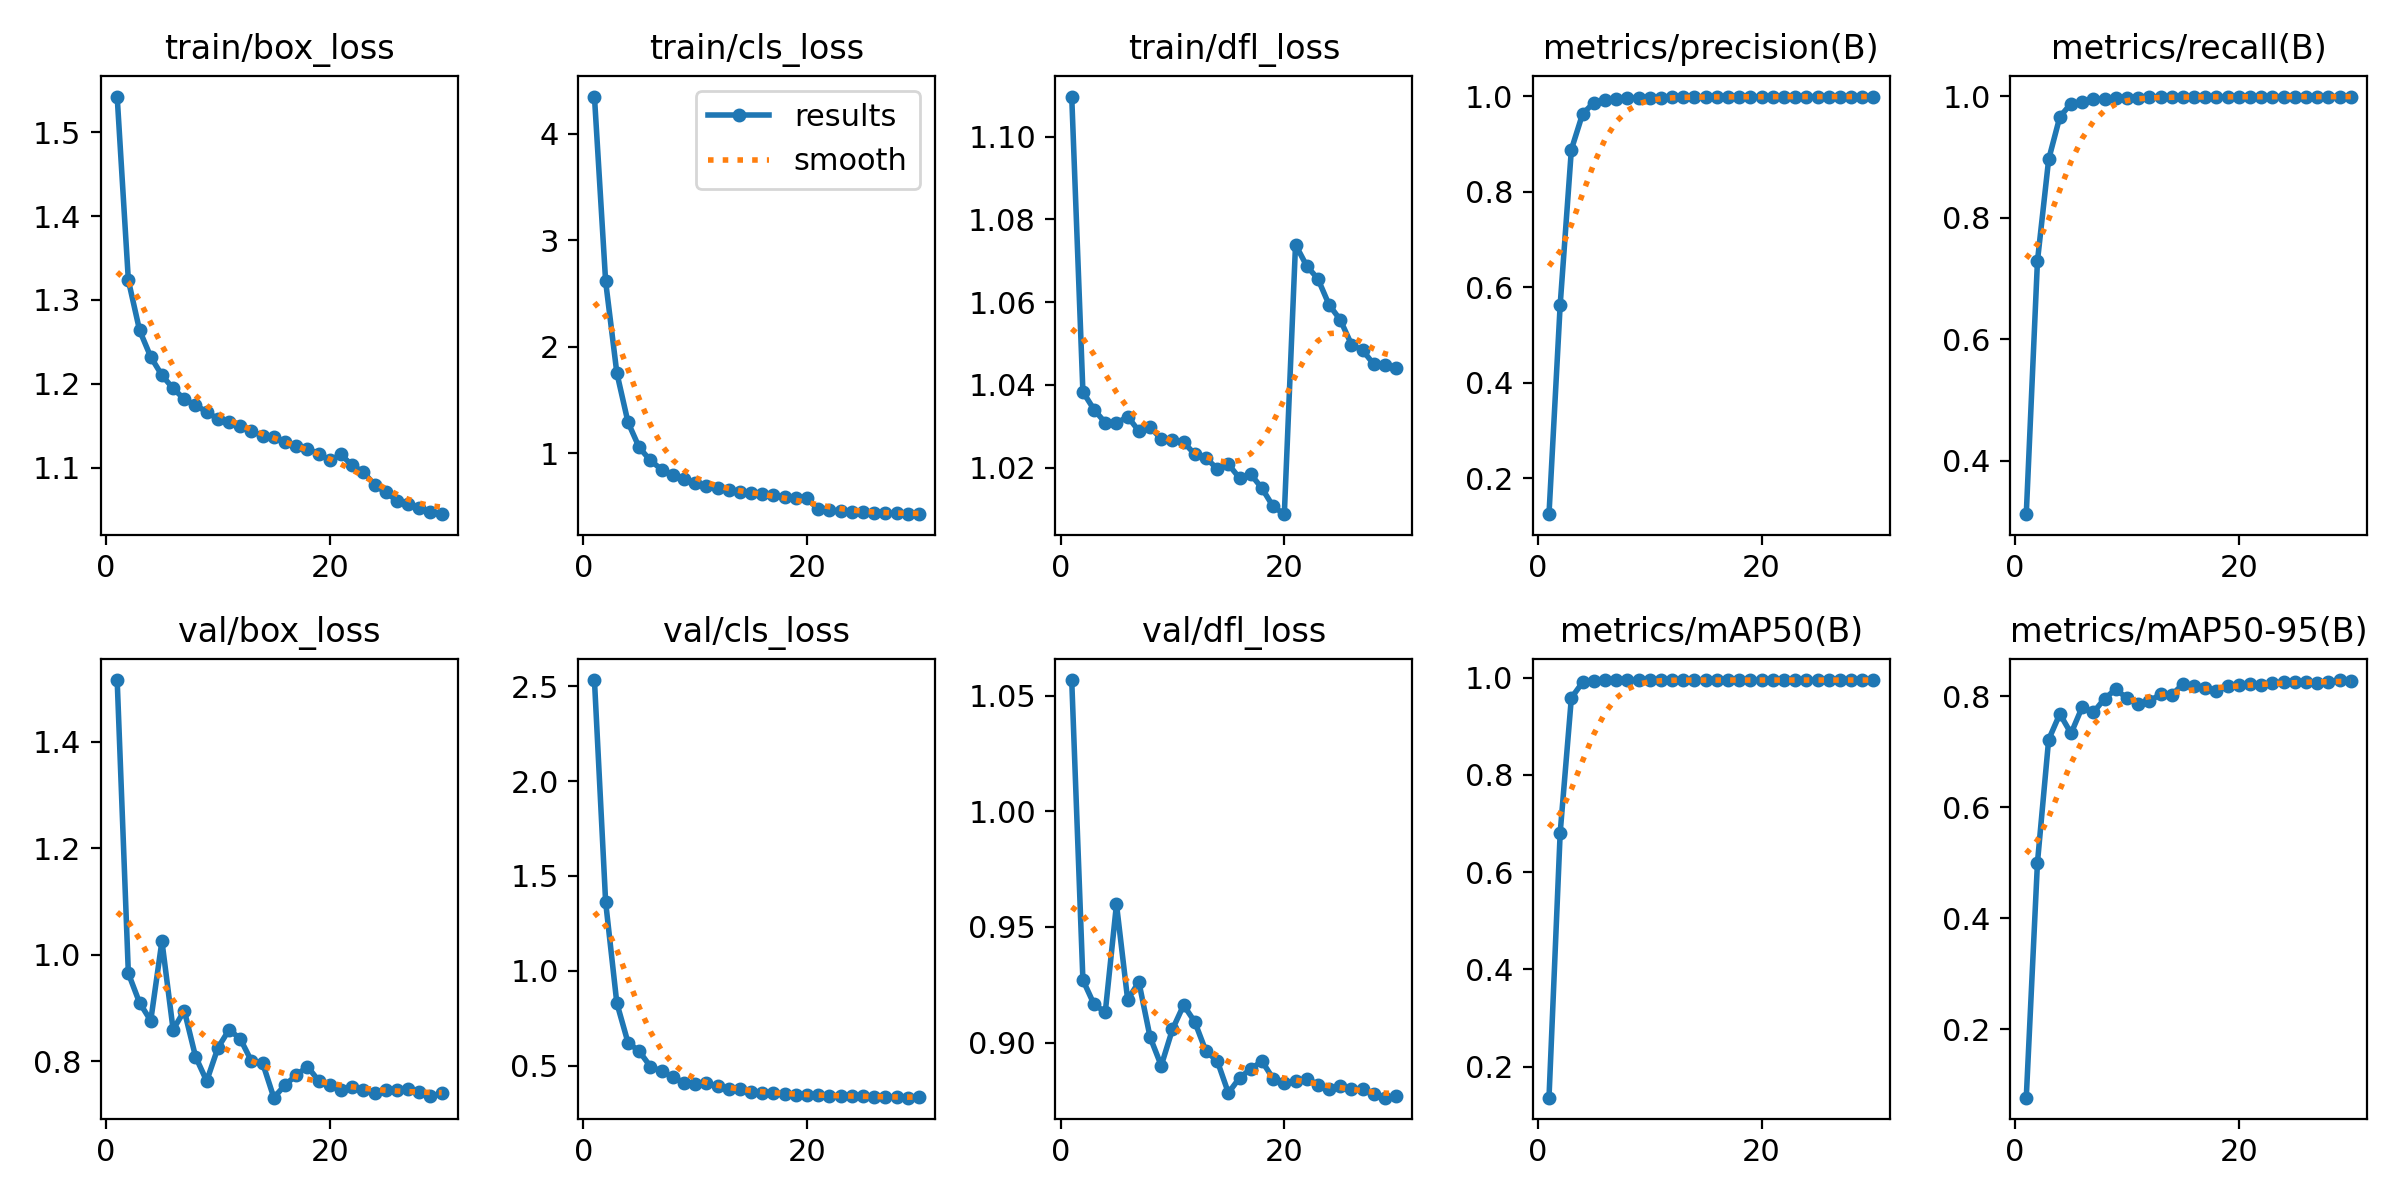

In [18]:
from IPython.display import Image
Image(filename='runs/detect/yolo11n_poker3/results.png', width=1200)

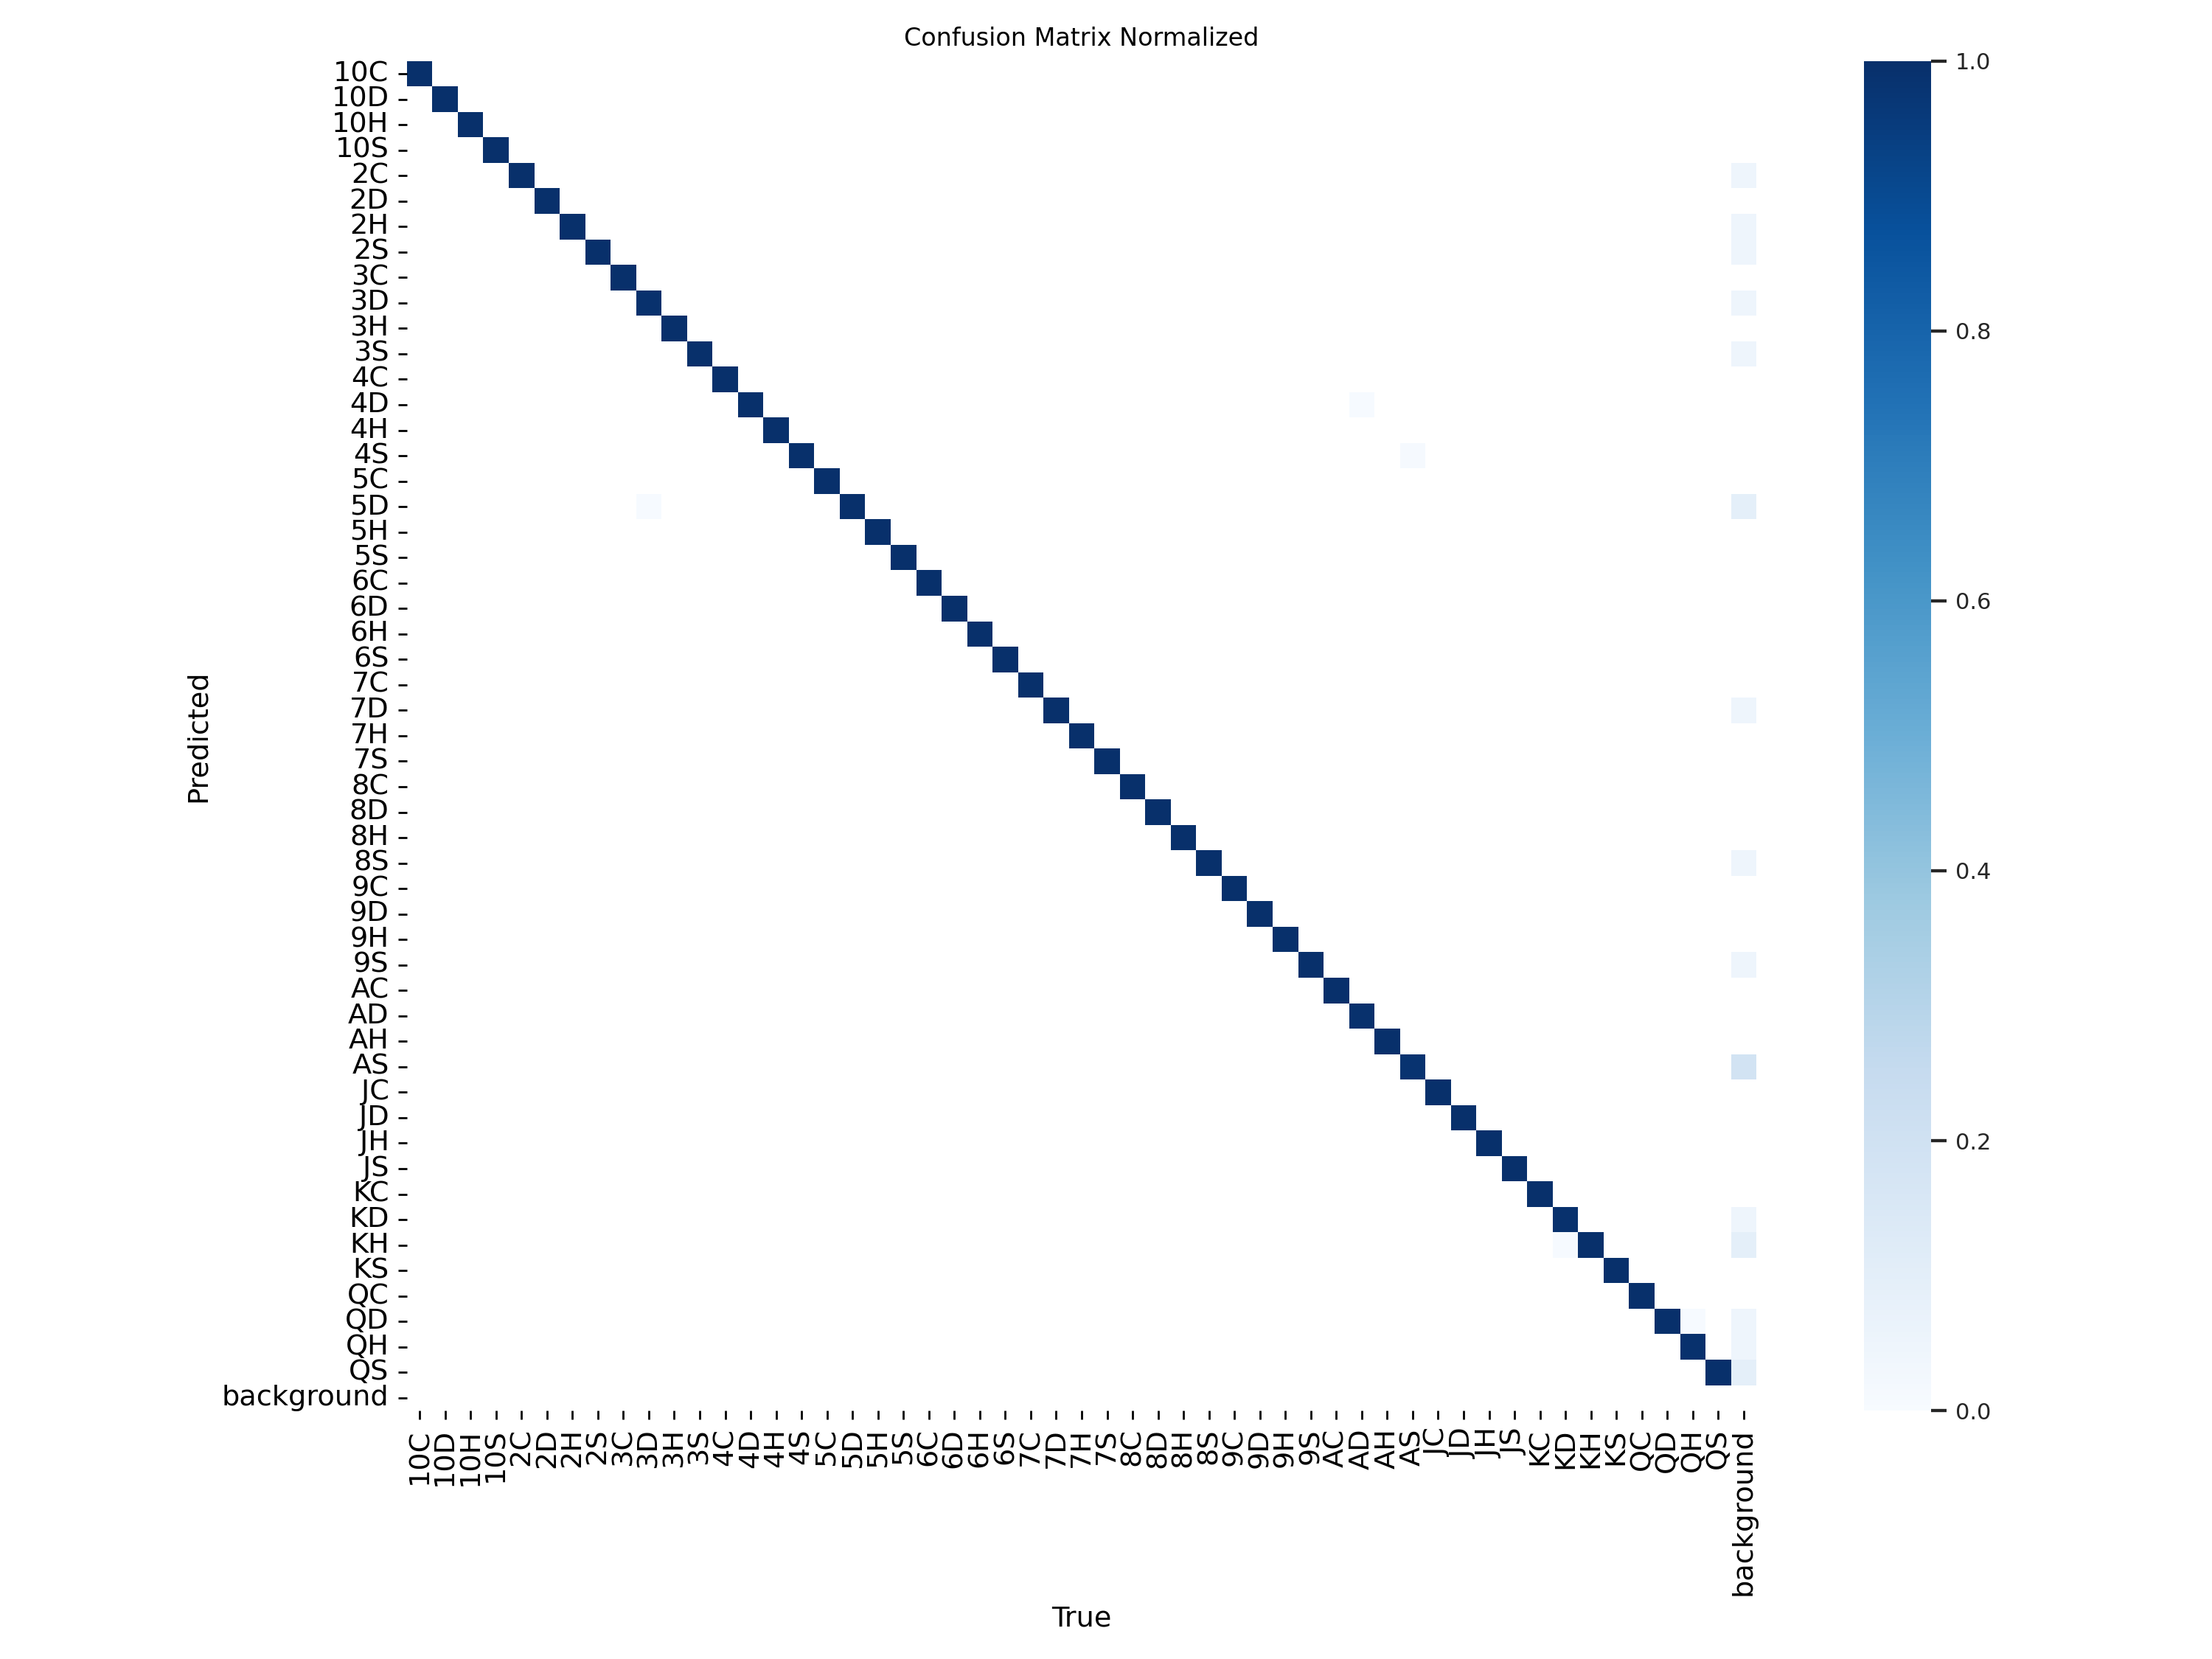

In [19]:
Image(filename='runs/detect/yolo11n_poker3/confusion_matrix_normalized.png', width=1000)

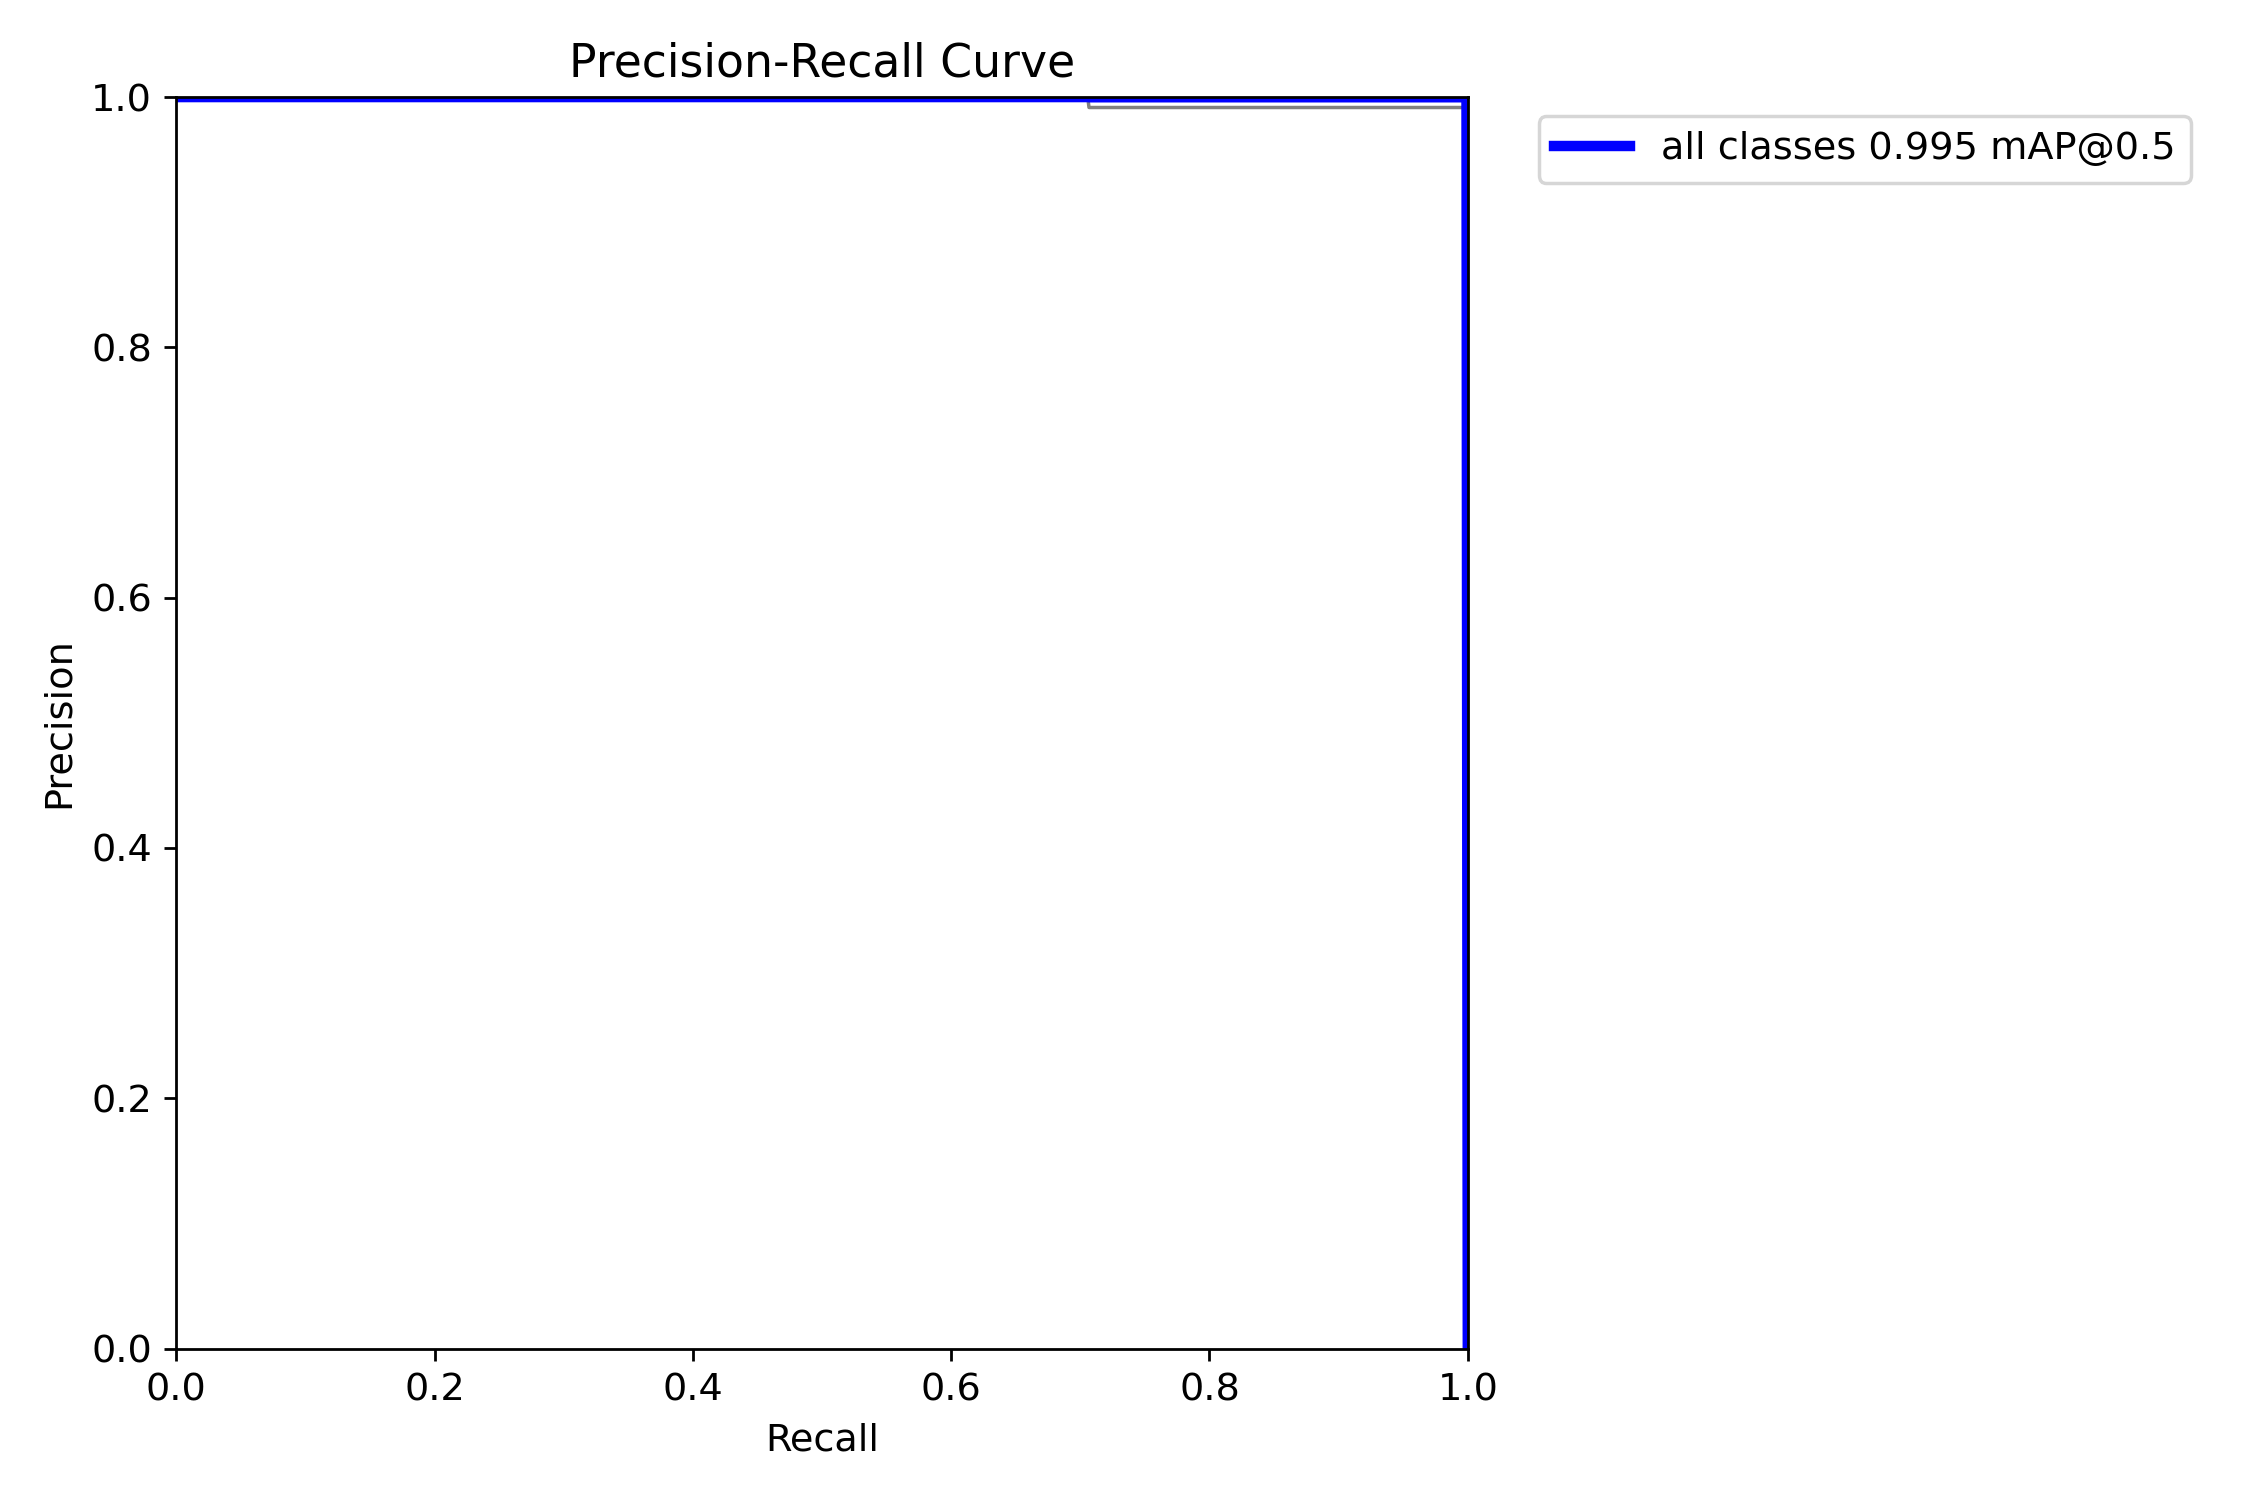

In [20]:
Image(filename='runs/detect/yolo11n_poker3/PR_curve.png', width=600)

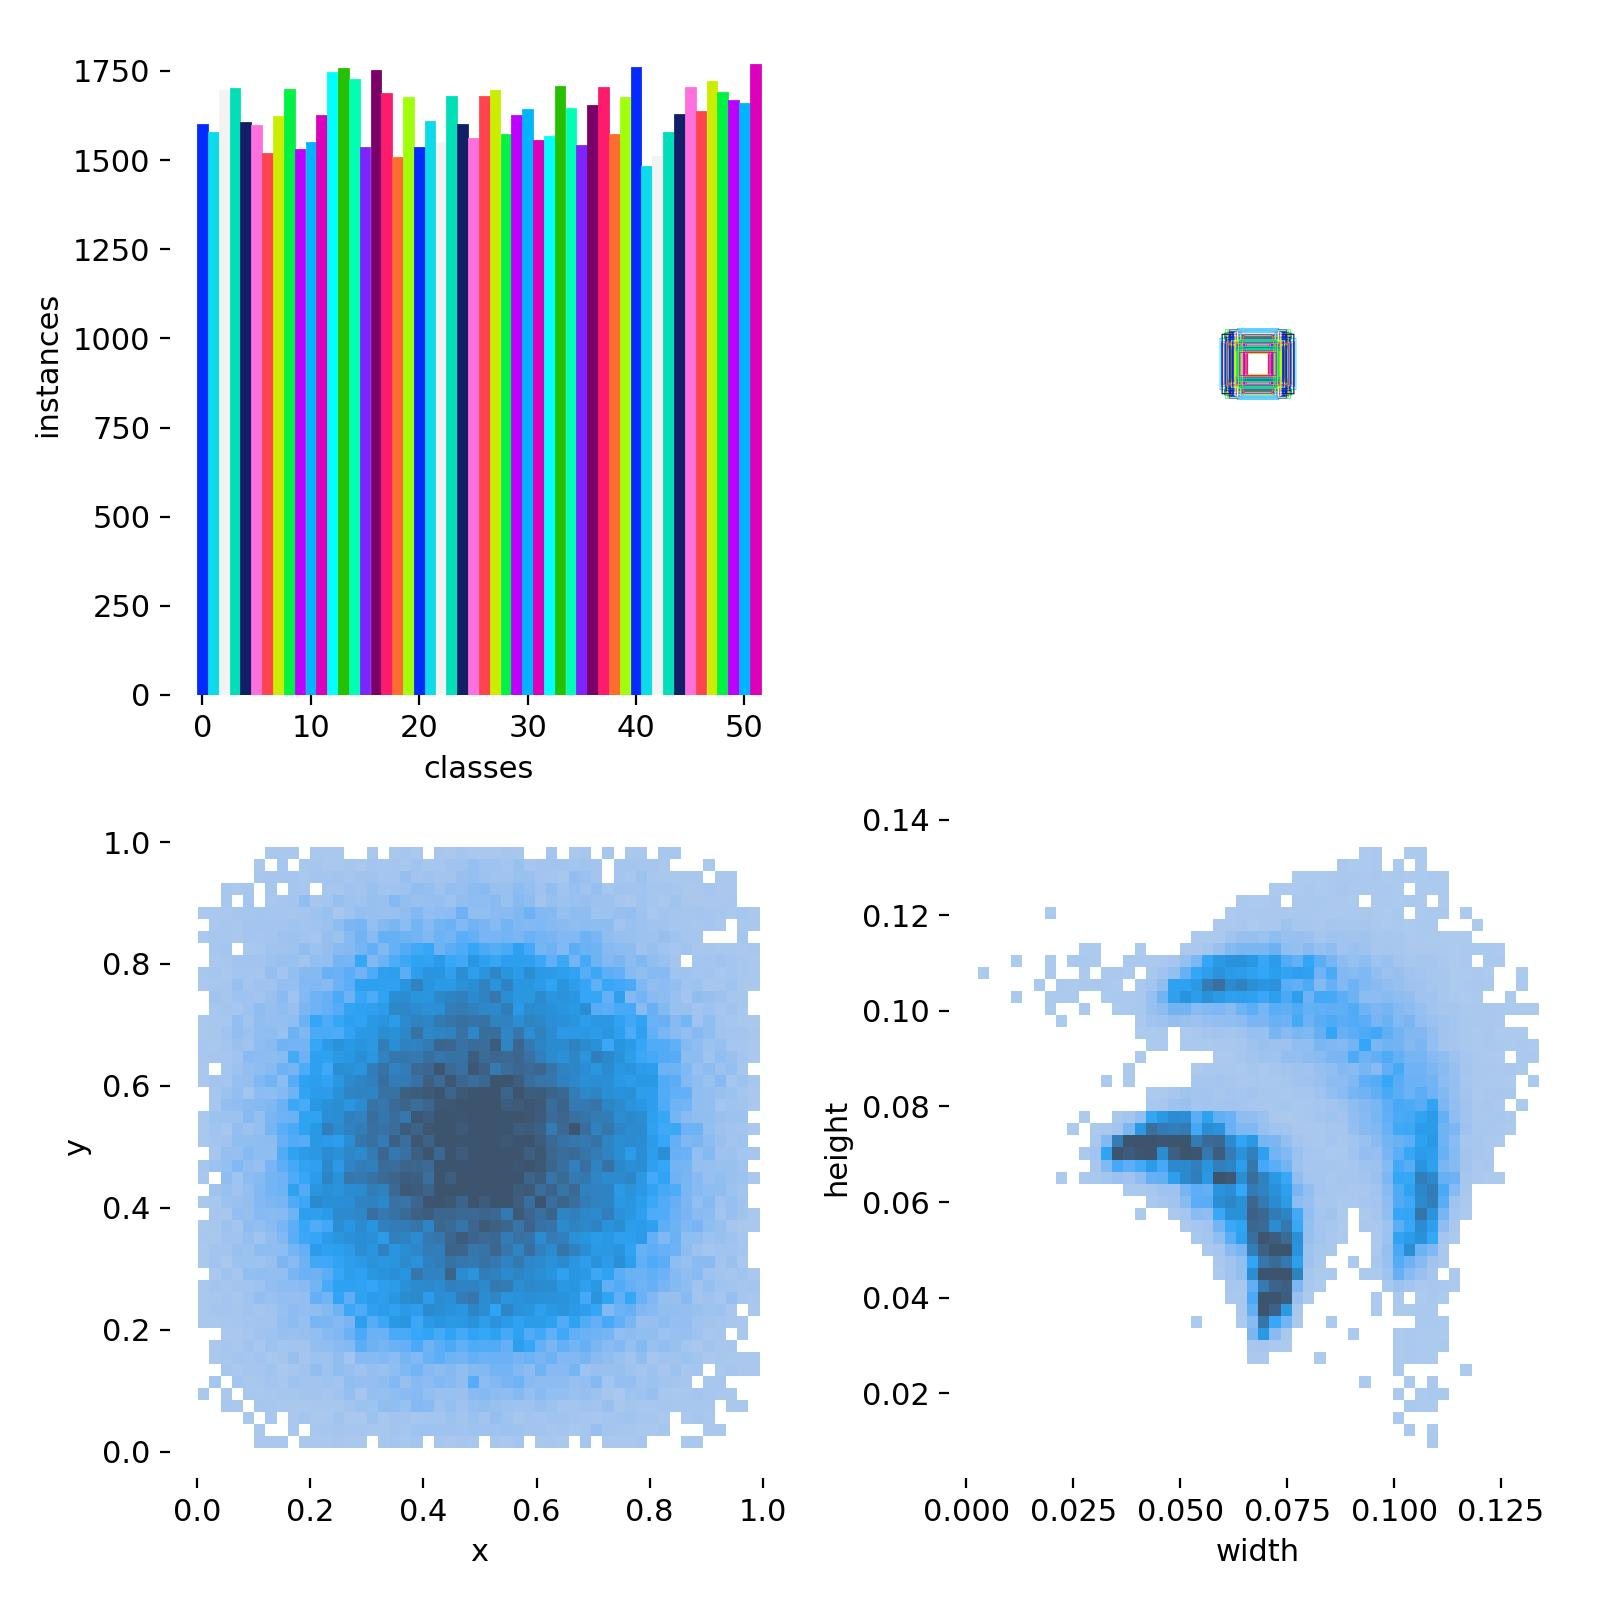

In [21]:
Image(filename='runs/detect/yolo11n_poker3/labels.jpg', width=600)